## Representational Similarity Analysis 

#### Load Packages and Define Functions

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from matplotlib.patches import Patch


import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
import scipy.spatial.distance as sp_distance
from scipy.stats import kendalltau
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns 
from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

In [2]:
def load_data(sub_id, all_sub_ids, data_dir, roi_name):
    """ Load data for on ROI and one participant """
    assert sub_id in all_sub_ids
    images = scipy.io.loadmat(os.path.join(data_dir, '%s_images.mat' % (sub_id)))['images']  
    data = scipy.io.loadmat(os.path.join(data_dir, '%s_roi_data.mat' % (sub_id))) 
    roi_data_all = data['roi_data']
    roi_names = data['roinames']
    labels = np.array(data['labels'])
    categoryNames = data['categoryNames']
    n_categories = categoryNames.shape[1]
    n_rois = roi_names.shape[1]
    categories = [categoryNames[0, i][0] for i in range(n_categories)]
    roi_names = [roi_names[0, i][0] for i in range(n_rois)]
    labels = np.squeeze(labels) 
    label_dict = {categories[i]: i+1 for i in range(len(categories))}
    roi_data = []
    for r in range(n_rois): 
        if roi_names[r] in roi_name: 
            roi_data.append(roi_data_all[0, r])
    n_rois = len(roi_name)
    return images, roi_data, roi_name, n_rois, categories, n_categories, labels, label_dict

In [176]:
def plot_RM(matrix, vmin, vmax, type, labels, categories, roi_name):
    """ Plot a RDM or a RSM """
    f, ax = plt.subplots(1,1, figsize=(10, 8))
    plt.imshow(matrix, cmap='viridis', vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.grid(False)

    binsize = np.histogram(labels, 6)[0]
    edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])
    ticks = [(a + b) / 2.0 for a,b in zip(edges, edges[1:])]
    ax.set_xticks((ticks))
    #ax.set_xticks(list(np.array(edges)+6))
    
    ax.set_xticklabels(categories, rotation = 10, fontsize = 8)
    #ax.set_yticks(list(np.array(edges)+3))
    ax.set_yticks((ticks))
    ax.set_yticklabels(categories, fontsize = 8)
    ax.vlines(edges[:-1]-0.5, 0-0.5, 96-0.5, colors="k")
    ax.hlines(edges[:-1]-0.5, 0-0.5, 96-0.5, colors = "k")
    ax.set_title(f'{type}, ROI: {roi_name}')
    plot_path = f"../out/{type}.png"
    plt.savefig(plot_path)
    return plt

#### Load and Inspect Data 
Participant 'KO' and ROI 'lFFA' (left fusiform face area)

In [4]:
sub_id = "KO"
data_dir = '/work/notebooks_fMRI/data/NinetySix'
roi_name = ["lFFA"]
all_sub_ids = {'BE', 'KO', 'SN', 'TI'}

In [5]:
images, roi_data, roi_name, n_rois, categories, n_categories, labels, label_dict = load_data(sub_id, all_sub_ids, data_dir, roi_name)
n_stimuli = len(images)

In [6]:
print('ROI:', roi_name[0])
print(f'Stimulus categories: {([str(x) for x in categories])}')
print(type(labels))
print('Trial labels:', labels)
print('Region of interest matrix sizes:')
for roi in roi_data:
    print (roi.shape)
print(f"Number of trials: {roi.shape[0]}, Number of voxels: {roi.shape[1]}")

ROI: lFFA
Stimulus categories: ['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']
<class 'numpy.ndarray'>
Trial labels: [2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 6
 6 6 6 6 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Region of interest matrix sizes:
(96, 293)
Number of trials: 96, Number of voxels: 293


In [7]:
labels = [int(x) for x in labels] #make labels into integers
R = roi_data[0] #extract roi_data
roi_name = roi_name[0] #extract roi_name
categories = [str(x) for x in categories] #make categories strings

#### Visualise Data

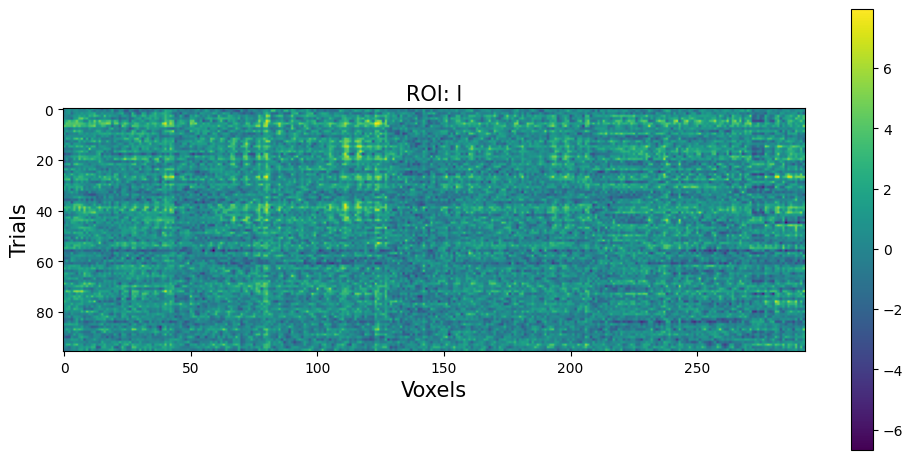

In [8]:
fig, axis = plt.subplots(1,1, figsize=(10, 5))
fig.tight_layout()
plt.imshow(R, cmap='viridis')
axis.set_title(f"ROI: {roi_name[0]}", fontsize=15)
axis.set_xlabel("Voxels", fontsize=15)
axis.set_ylabel("Trials", fontsize=15)
plt.colorbar()

Text(0, 0.5, 'Stimulus category')

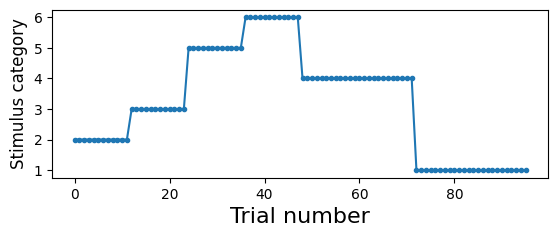

In [9]:
plt.figure()
plt.subplot(2,1,2)
plt.plot(labels,'.-')
plt.xlabel('Trial number', fontsize=16)
plt.ylabel('Stimulus category', fontsize=12)

#### Representational Similarity and Dissimilarity Matrices
Both matrices are visualised with the categories ordered so animate labels are closer together and inanimate labels are closer together. Similarity/dissimilarity measure used is cosine. 

In [10]:
#define new order of categories
categories_ord = ('human face', 'human bodypart', 'nonhuman face', 'nonhuman bodypart', 'natural inanimate', 'artificial inanimate')

# Make a loop to make a vector of new labels
category_vec=[]
labels_ord=[]
for nn in range(len(labels)):
    #Make a vector with category names, rather than numeric labels
    category_vec.append(categories[labels[nn]-1])
    # Compare current category to new order, to make a vector of labels according the the new order
    for nnn in range(len(categories_ord)):
        if category_vec[nn]==categories_ord[nnn]:
            labels_ord.append(nnn)
#Make a new sorting index to use for plotting
labels_ord=np.array(labels_ord)
ids_ord = labels_ord.argsort()

R_ord = roi_data[0][ids_ord, :]

##### RSM

<module 'matplotlib.pyplot' from '/work/LauraGivskovRahbek#6659/advanced_cognitive_neuroscience24/env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

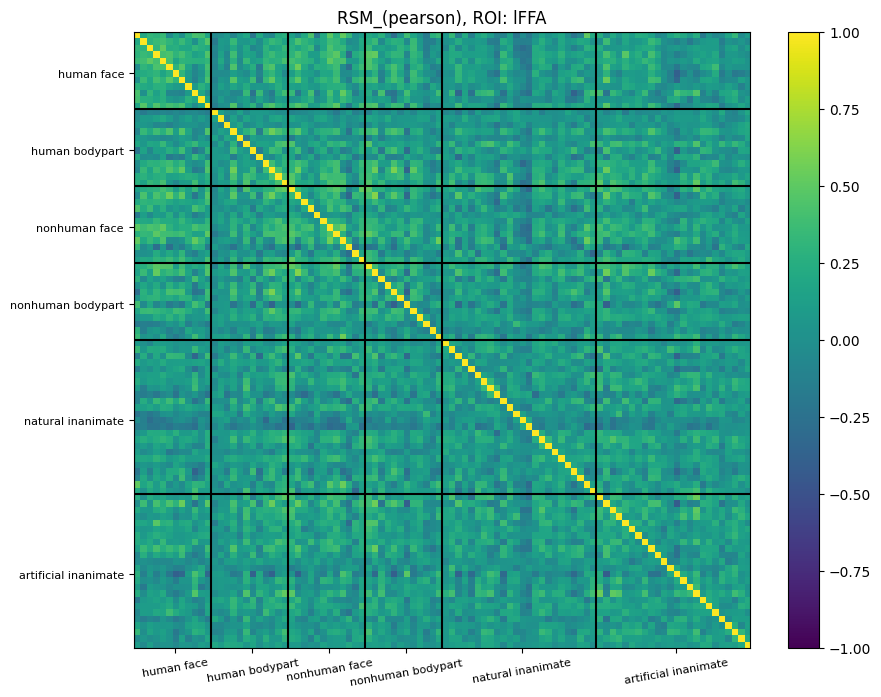

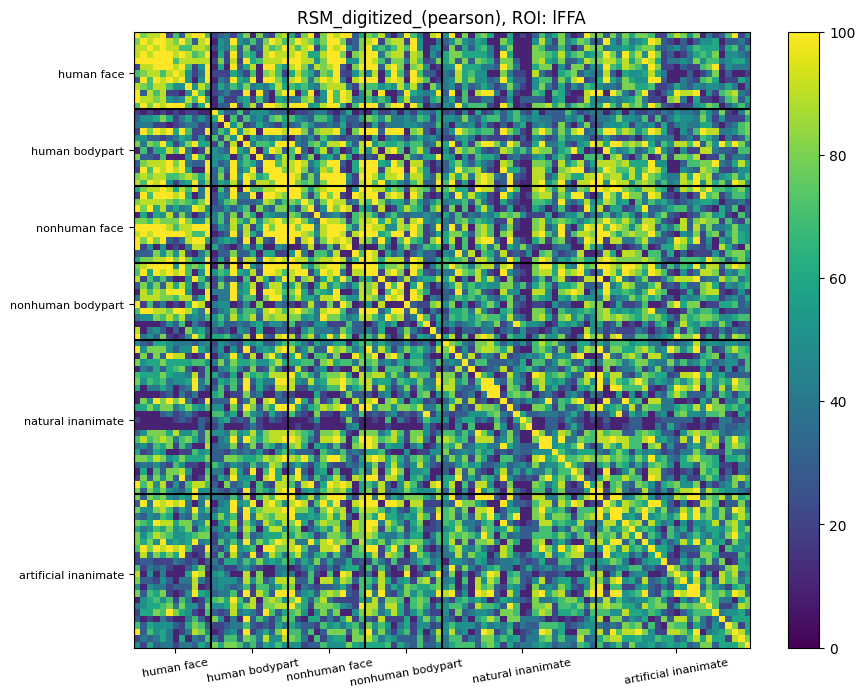

In [178]:
# Plot Pearson correlation and digtitized Pearson correlation
rsm_p = np.corrcoef(R_ord)
plot_RM(rsm_p, -1, 1, "RSM_(pearson)", labels_ord, categories_ord, roi_name)
plot_RM(digitize_rdm(rsm_p), 0, 100, "RSM_digitized_(pearson)", labels_ord, categories_ord, roi_name)

<module 'matplotlib.pyplot' from '/work/LauraGivskovRahbek#6659/advanced_cognitive_neuroscience24/env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

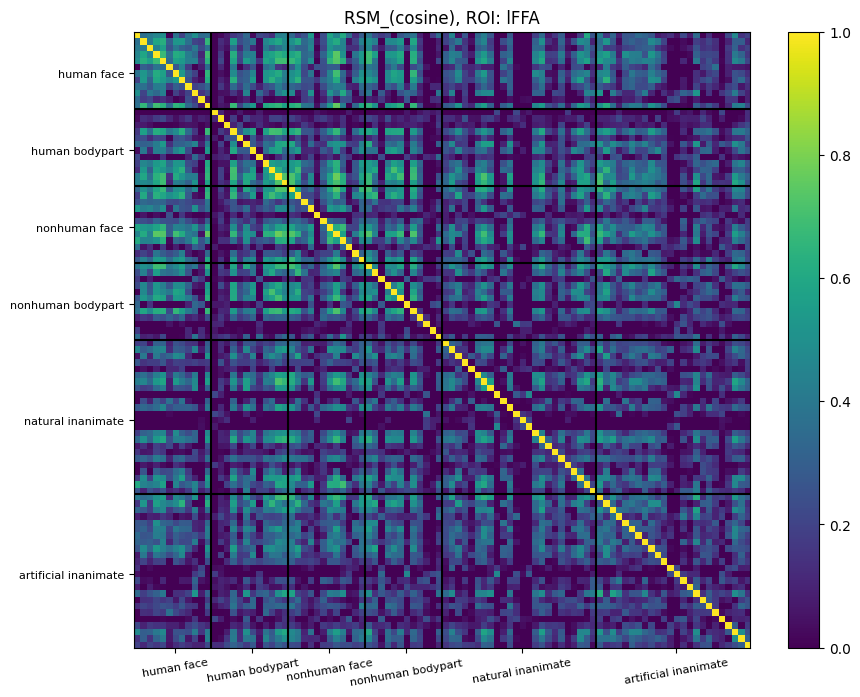

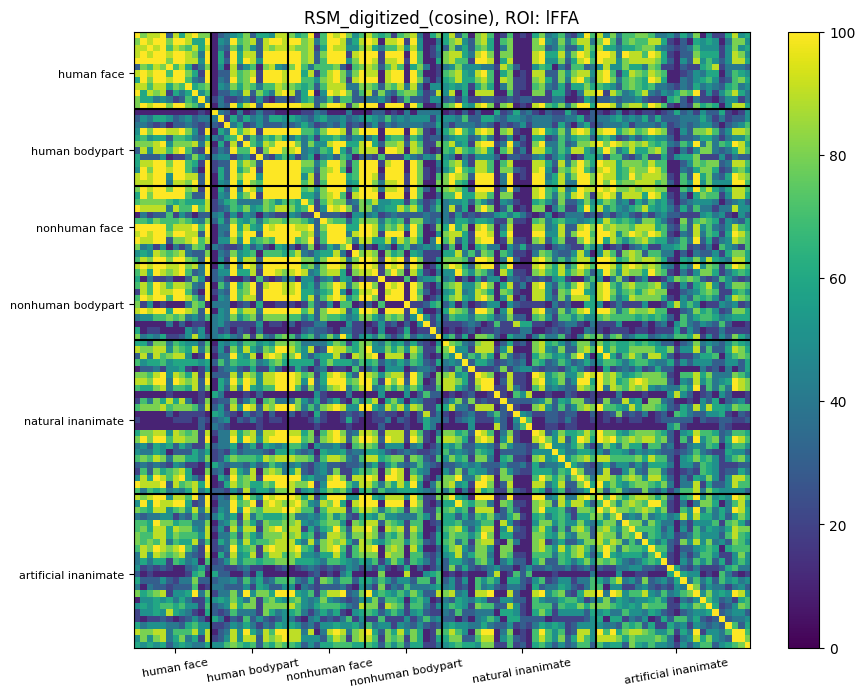

In [179]:
# Plot cosine similarity and digtitized cosine similarity correlation
rsm_cos = cosine_similarity(R_ord)
plot_RM(rsm_cos, 0, 1, "RSM_(cosine)", labels_ord, categories_ord, roi_name)
plot_RM(digitize_rdm(rsm_cos), 0, 100, "RSM_digitized_(cosine)", labels_ord, categories_ord, roi_name)

##### RDM

<module 'matplotlib.pyplot' from '/work/LauraGivskovRahbek#6659/advanced_cognitive_neuroscience24/env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

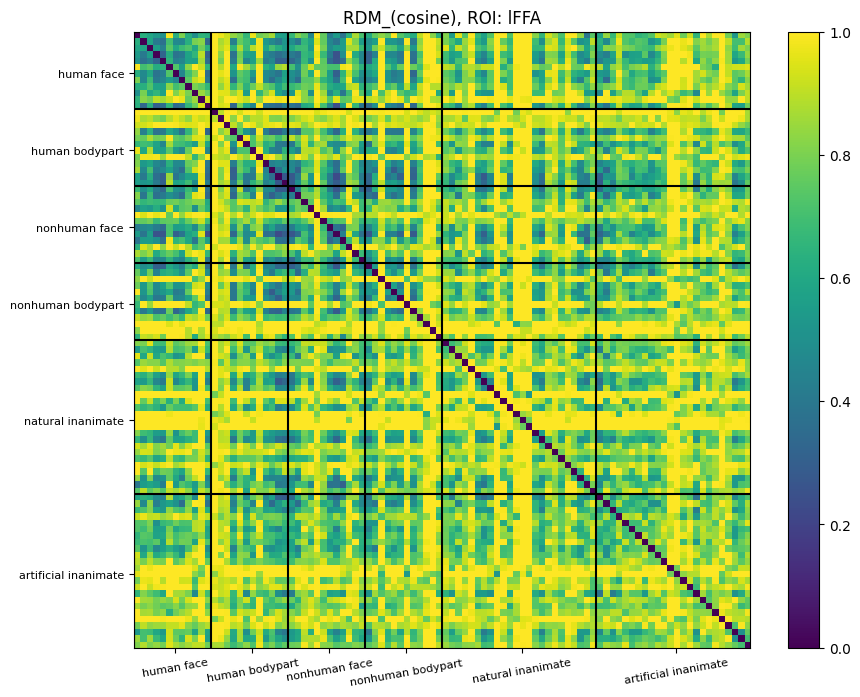

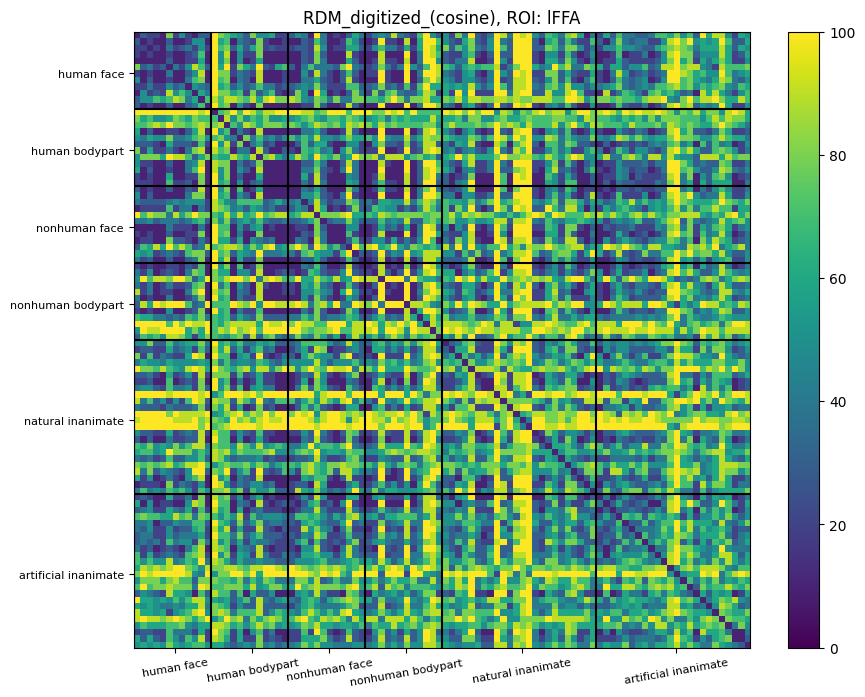

In [180]:
rdm_cos = cosine_distances(R_ord)
plot_RM(rdm_cos, 0, 1, "RDM_(cosine)", labels_ord, categories_ord, roi_name)
plot_RM(digitize_rdm(rdm_cos), 0, 100, "RDM_digitized_(cosine)", labels_ord, categories_ord, roi_name)

In [101]:
cols = sns.color_palette("crest")[1:5] + sns.color_palette("rocket")[1:3]
col_dict = dict(zip(categories_ord, cols))

cat_nm = pd.Series(category_vec)
cat_cols = cat_nm.map(col_dict).to_list()

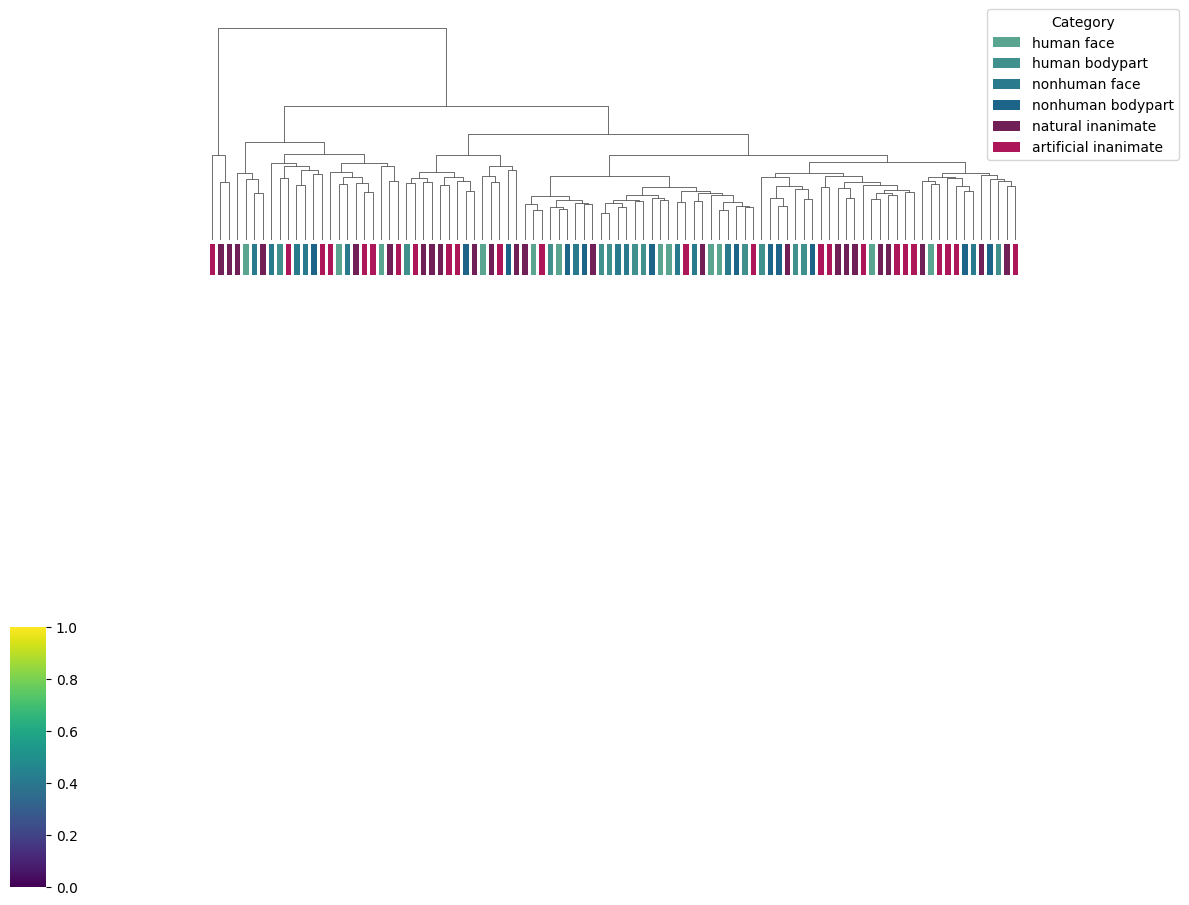

In [125]:
#rsm for animate and human 
rsm_cos_a = cosine_similarity(roi_data[0][ids_ord, :][:48,])
rdm_cos_a = cosine_distances(roi_data[0][ids_ord, :][:48,])

g = sns.clustermap(rdm_cos, square = True, cmap="viridis", vmin = 0, vmax = 1, 
                   dendrogram_ratio=(.2, .2), 
                   #cbar = False,
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13), 
                   xticklabels = category_vec, yticklabels = category_vec, 
                   col_colors = cat_cols)
g.ax_heatmap.remove()
g.ax_row_dendrogram.remove()
handles = [Patch(facecolor=col_dict[name]) for name in col_dict]
plt.legend(handles, col_dict, title='Category',
           bbox_to_anchor=(1, 1), 
           bbox_transform=plt.gcf().transFigure, loc='upper right', )


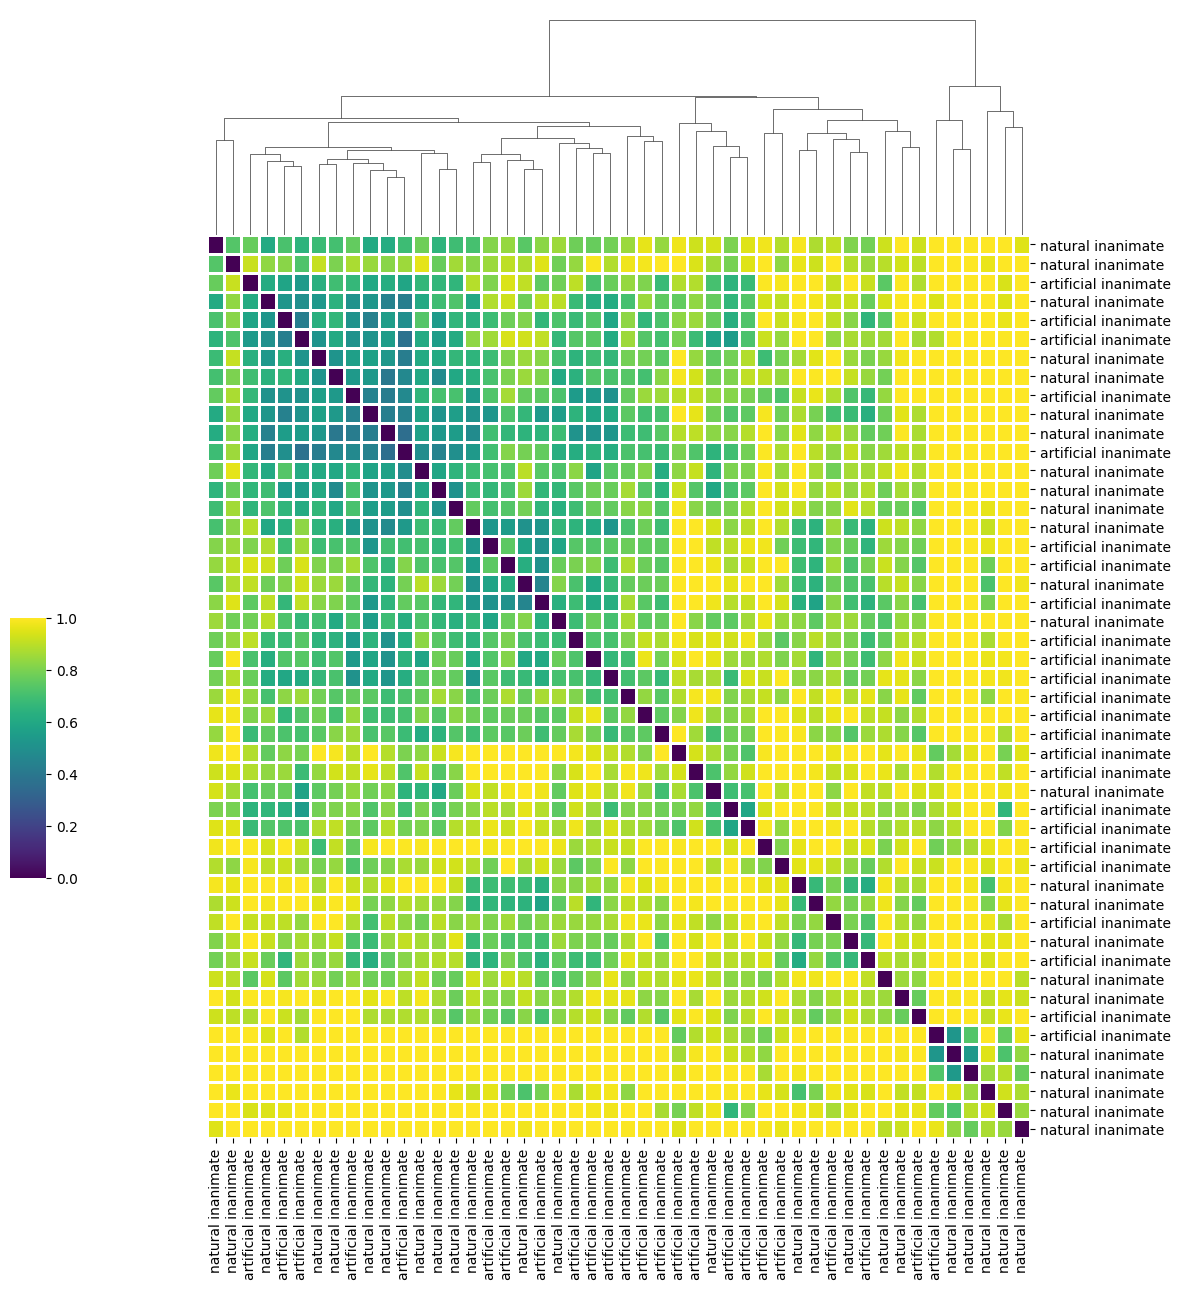

In [26]:
#rsm for animate and human 
R_ina = roi_data[0][ids_ord, :][48:,]
rsm_cos_ina = cosine_similarity(R_ina)
rdm_cos_ina = cosine_distances(R_ina)

g = sns.clustermap(rdm_cos_ina, square = True, cmap="viridis", 
                   vmin = 0, vmax = 1, 
                   dendrogram_ratio=(.2, .2), cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13), 
                   xticklabels = category_vec[48:], yticklabels = category_vec[48:])
g.ax_row_dendrogram.remove()

#### Model the RDM

In [27]:
labels_an=1*(labels_ord<=3)
labels_hum=1*(labels_ord<=1)
labels_hum_face=1*(labels_ord==0)

In [28]:
rdm_group = []
for group in [labels_an, labels_hum, labels_hum_face]:
    x1 = np.tile(group[ids_ord], (sum(group), 1))
    x2 = np.zeros((len(group)-sum(group), len(group)), dtype=int)
    rdm_g = abs(1-np.concatenate((x1, x2), axis=0))
    np.fill_diagonal(rdm_g, 0)
    rdm_group.append(rdm_g)
rdm_an, rdm_hum, rdm_hum_face = rdm_group

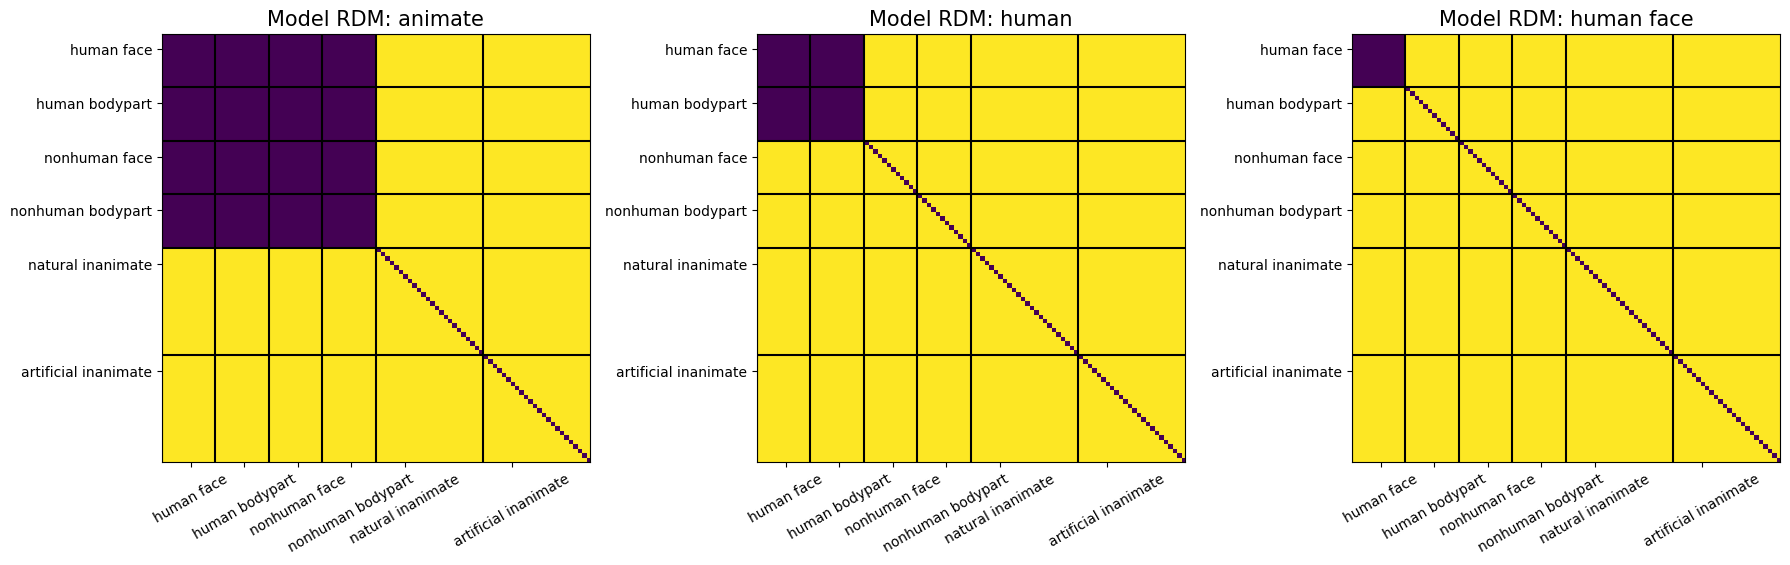

In [126]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
binsize = np.histogram(labels_ord, 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
axes[0].imshow(rdm_an, cmap = 'viridis')
axes[0].set_title("Model RDM: animate", fontsize=15)
axes[1].imshow(rdm_hum, cmap = 'viridis')
axes[1].set_title("Model RDM: human", fontsize=15)
axes[2].imshow(rdm_hum_face, cmap='viridis')
axes[2].set_title("Model RDM: human face", fontsize=15)
for i in range(3):
    axes[i].set_xticks(list(np.array(edges)+6))
    axes[i].set_xticklabels(categories_ord, rotation = 30)
    axes[i].set_yticks(list(np.array(edges)+3))
    axes[i].set_yticklabels(categories_ord)
    axes[i].vlines(edges-0.5, 0-0.5, 96-0.5, colors="k")
    axes[i].hlines(edges-0.5, 0-0.5, 96-0.5, colors = "k")
    axes[i].grid(False)
fig.tight_layout()
fig.show()
fig.savefig("../out/feature_rdm.png")

#### Correlation Test (RDM cosine) with Kendalls Tau

In [30]:
# Let's extract the RDV from our neural RDM
rdv_cos = squareform(rdm_cos.round(5))
print("Shape rdv_cos:", rdv_cos.shape)
rdv_an = squareform(rdm_an)
print("Shape rdv_an:", rdv_an.shape)
rdv_hum = squareform(rdm_hum)
print("Shape rdv_hum:", rdv_an.shape)
rdv_hum_face = squareform(rdm_hum_face)
print("Shape rdv_hum_face:", rdv_hum_face.shape)

Shape rdv_cos: (4560,)
Shape rdv_an: (4560,)
Shape rdv_hum: (4560,)
Shape rdv_hum_face: (4560,)


In [31]:
rdm_an_corr, pval = kendalltau(rdv_an, rdv_cos)
print("Correlation between animate RDM and RDM(lFFA cosine) (p-value): %.3f (%.3f)" % (rdm_an_corr, pval))
rdm_hum_corr, pval = kendalltau(rdv_hum, rdv_cos)
print("Correlation between human RDM and RDM(lFFA cosine) (p-value): %.3f (%.3f)" % (rdm_hum_corr, pval))
rdm_hum_face_corr, pval = kendalltau(rdv_hum_face, rdv_cos)
print("Correlation between face RDM and RDM(lFFA cosine) (p-value): %.3f (%.3f)" % (rdm_hum_face_corr, pval))

Correlation between animate RDM and RDM(lFFA cosine) (p-value): 0.107 (0.000)
Correlation between human RDM and RDM(lFFA cosine) (p-value): 0.073 (0.000)
Correlation between face RDM and RDM(lFFA cosine) (p-value): 0.082 (0.000)
